In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')

In [10]:
df_tr_app_events_sparse = load_sparse_csr('data/df_tr_app_events.npz')
rows1tr = pd.read_csv('data/rows1tr.csv')

In [12]:
df_tr_app_events = pd.DataFrame(df_tr_app_events_sparse.toarray())

In [14]:
df_tr_app_events.index = rows1tr['device_id']

In [30]:
#118724
a = pd.Series(df_tr_app_events.sum())

In [34]:
a[a>118724]

9623    118724.010261
dtype: float64

In [38]:
df_tr_app_events.drop([9623],axis=1,inplace=True)

In [39]:
df_tr_app_events.shape

(12476, 10115)

In [22]:
targetencoder = LabelEncoder().fit(gatrain.ix[df_tr_app_events.index].group)
y = targetencoder.transform(gatrain.ix[df_tr_app_events.index].group)
nclasses = len(targetencoder.classes_)

In [94]:
def score(clf, random_state = 24):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        return log_loss(yte, pred[itest, :])
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

Cs = np.logspace(-3,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [42]:
import xgboost as xgb
dtrain = xgb.DMatrix(csr_matrix(df_tr_app_events), y)

In [61]:
params = {
        "eta": 0.3,
        "booster": "gbtree",
        "objective": "multi:softprob",
        "max_depth": 3,
        "gamma": 0.3,
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "silent": 1,
        "seed": 1233,
        "num_class": 12,
        "nthread": 16,
        "eval_metric": "mlogloss"
    }

In [62]:
xgb.cv(params, dtrain, 
       num_boost_round=10000, 
       early_stopping_rounds = 20, 
       maximize = False,
       nfold=5,
       stratified=True,
       verbose_eval=10)

[0]	train-mlogloss:2.38551+0.00212221	test-mlogloss:2.4024+0.00313538
[10]	train-mlogloss:2.03947+0.00215676	test-mlogloss:2.1716+0.00632376
[20]	train-mlogloss:1.89973+0.0032087	test-mlogloss:2.11897+0.00828652
[30]	train-mlogloss:1.8017+0.00274795	test-mlogloss:2.09854+0.00866225
[40]	train-mlogloss:1.72295+0.0031276	test-mlogloss:2.08526+0.00764471
[50]	train-mlogloss:1.6563+0.00450869	test-mlogloss:2.07734+0.00782482
[60]	train-mlogloss:1.5964+0.00514728	test-mlogloss:2.07232+0.00980584
[70]	train-mlogloss:1.54302+0.00407783	test-mlogloss:2.06805+0.0112398
[80]	train-mlogloss:1.49336+0.00461083	test-mlogloss:2.06584+0.0119663
[90]	train-mlogloss:1.44853+0.00507031	test-mlogloss:2.0646+0.0123073
[100]	train-mlogloss:1.40719+0.0059264	test-mlogloss:2.06556+0.0144705
[110]	train-mlogloss:1.36823+0.00584503	test-mlogloss:2.06605+0.0147907


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,2.402401,0.003135,2.385509,0.002122
1,2.345507,0.003686,2.315201,0.002170
2,2.305561,0.004415,2.261820,0.002154
3,2.275109,0.004451,2.218485,0.001232
4,2.250508,0.006138,2.182705,0.001377
5,2.231612,0.006477,2.152241,0.000941
6,2.214663,0.007932,2.124854,0.001222
7,2.201581,0.007883,2.100704,0.001443
8,2.190276,0.007477,2.078551,0.001751
9,2.179991,0.006856,2.058141,0.001972


In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

2.04208 2.02506 2.03599 2.01712 2.00233 2.01351 2.01541 2.03365 2.02277 2.03831 2.02462 2.03400 2.01593 2.02786 2.00919 1.99293 2.00518 2.00676 2.02544 2.01409 2.03218 2.01635 2.02738 2.01025 2.02144 2.00378 1.98523 1.99974 2.00085 2.02008 2.00804 2.02701 2.01038 2.02395 2.00701 2.01742 2.00187 1.98088 1.99632 1.99623 2.01729 2.00406 2.02442 2.00694 2.02248 2.00610 2.01563 2.00215 1.97832 1.99566 1.99387 2.01698 2.00304 2.02444 2.00586 2.02357 2.00758 2.01645 2.00567 1.97833 1.99810 1.99476 2.01929 2.00459 2.02550 2.00738 2.02670 2.01345 2.01958 2.01064 1.98042 2.00252 1.99811 2.02466 2.01008 2.02993 2.01160 2.03461 2.02216 2.02487 2.02130 1.98605 2.00807 2.00443 2.03668 2.02061 2.03831 2.01970 2.04437 2.03111 2.03752 2.03556 1.99077 2.02932 2.01304 2.04374 2.03099 2.04722 2.03036 2.06670 2.04084 2.05142 2.05176 2.00599 2.04072 2.02782 2.06491 2.04717 2.06256 2.04598 

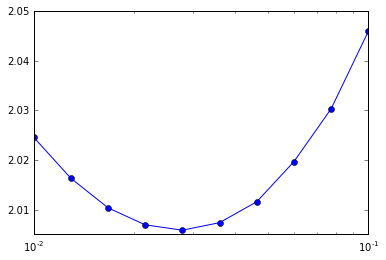

In [68]:
Cs = np.logspace(-2,-1,10)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [69]:
np.logspace(-2,-1,10)

array([ 0.01      ,  0.0129155 ,  0.01668101,  0.02154435,  0.02782559,
        0.03593814,  0.04641589,  0.05994843,  0.07742637,  0.1       ])

In [72]:
#0.02782559
score(LogisticRegression(C = 0.02782559, multi_class='multinomial',solver='lbfgs'))

2.00386 

2.0038583531682344

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
pca.fit(df_tr_app_events)

PCA(copy=True, n_components=0.999, whiten=False)

In [75]:
print(pca.n_components_)

3111


In [76]:
Xtrain_new = pca.transform(df_tr_app_events)

In [84]:
Xtrain = csr_matrix(Xtrain_new)

In [87]:
Xtrain.shape

(12476, 3111)

In [86]:
score(LogisticRegression(C = 0.02782559, multi_class='multinomial',solver='lbfgs'))

2.02335 2.00637 2.01538 

KeyboardInterrupt: 

In [103]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_new, y)
params = {
        "eta": 0.3,
        "booster": "gbtree",
        "objective": "multi:softprob",
        "max_depth": 5,
        "silent": 1,
        "seed": 1233,
        "num_class": 12,
        "nthread": 16,
        "eval_metric": "mlogloss"
    }

In [104]:
xgb.cv(params, dtrain, 
       num_boost_round=10000, 
       early_stopping_rounds = 20, 
       maximize = False,
       nfold=10,
       stratified=True,
       verbose_eval=10)

[0]	train-mlogloss:2.33506+0.000854135	test-mlogloss:2.38536+0.00530543
[10]	train-mlogloss:1.80025+0.0041391	test-mlogloss:2.13942+0.0164785
[20]	train-mlogloss:1.58663+0.00620401	test-mlogloss:2.09194+0.0226143
[30]	train-mlogloss:1.45792+0.00672583	test-mlogloss:2.07605+0.0265523
[40]	train-mlogloss:1.36162+0.00513704	test-mlogloss:2.06868+0.0293274
[50]	train-mlogloss:1.28191+0.0052866	test-mlogloss:2.06792+0.0298315
[60]	train-mlogloss:1.21357+0.00565554	test-mlogloss:2.06856+0.0301992


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,2.385356,0.005305,2.335062,0.000854
1,2.323365,0.008254,2.232456,0.001718
2,2.280256,0.009369,2.153086,0.002202
3,2.248039,0.010095,2.087226,0.002635
4,2.222386,0.013361,2.031566,0.002920
5,2.201524,0.013438,1.983009,0.002578
6,2.185329,0.014820,1.938991,0.002442
7,2.170451,0.014408,1.899712,0.003184
8,2.157886,0.015476,1.863756,0.003629
9,2.147742,0.015624,1.831014,0.003462


In [91]:
df_tr_app_events.shape

(12476, 10115)

In [92]:
Xtrain = csr_matrix(df_tr_app_events)

[ 0.2         0.21111111  0.22222222  0.23333333  0.24444444  0.25555556
  0.26666667  0.27777778  0.28888889  0.3       ]
2.01319 2.01278 2.01253 2.01232 2.01223 2.01222 2.01250 2.01305 2.01405 2.01493 

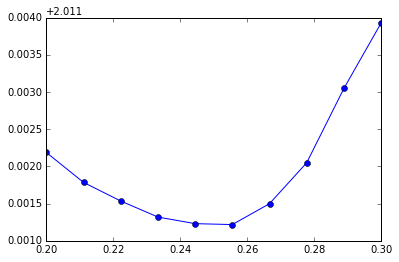

In [96]:
Cs = np.linspace(0.2,0.3,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, penalty="l1", dual=False)))
plt.plot(Cs, res,'-o');

In [97]:
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(C = 0.23333333, penalty="l1", dual=False).fit(Xtrain, y)
model = SelectFromModel(clf, prefit=True)

In [98]:
X_new = model.transform(Xtrain)

In [99]:
X_new.shape

(12476, 656)

In [105]:
save_sparse_csr('selectfrommodel_l1_logistic',X_new)

In [108]:
Y = pd.Series(y)

In [109]:
Y.to_csv('Y.csv',index_label='index',header=True)